# Amazon Fine Food Reviews Analysis





The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In this assignment I perform,

1.  Data reading
2.  Exploratory Data Analysis
3.  Text Preprocessing on Review text data and Summary data
4.  Sample data from dataset and split into Train and Test data

Next I do all the 4 featurizations - BoW, TFIDF, AvgW2V, TFIDF-W2V

5. On each featurization I apply DecisionTreeClassifier and Find Accuracy and error
6. Plot Heat maps, ROC curve, Confusion Matrix
7. Get top 20 important features for BoW and TFIDF
8. Visualize the Decision Tree using Graphviz for BoW and TFIDF


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [7]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.


#  [3] Text  Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1.  By removing stop-words, BoW vector will be small and more meaningful
2.  Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1.  Remove all URL's
2.  Remove all tags from the strings
3.  Expanding English language contractions like, you've -> you have
4.  Remove any punctuations or limited set of special characters like , or . or # etc.
5.  Check if the word is made up of english letters and is not alpha-numeric
6.  Remove words with numbers
7.  Remove spacial characters
8.  Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9.  Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1].  Preprocessing Review Text


In [9]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [10]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [11]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [12]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [14]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [15]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [17]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [02:51<00:00, 2124.85it/s]


In [20]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [21]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [22]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [23]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [24]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [25]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [26]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [28]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [29]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [01:55<00:00, 3153.10it/s]


In [32]:
summary_data[56000]

'awesome yummy'

In [33]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [34]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [35]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [4.1] Time Based Splitting


Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Cross Validate data is used to find best hyper parameter and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.



In [36]:
# sorting data using time
final_data['Time'] = pd.to_datetime(final_data['Time'])
final_data = final_data.sort_values(by = 'Time', ascending = True)


In [37]:
# display top 5 rows
final_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


### Sample the data from the Dataset

In [38]:
# taking top 100000 data points
total_score = final_data.iloc[:100000,:]
print(total_score.shape)
print(total_score['Score'].value_counts())

(100000, 12)
1    87729
0    12271
Name: Score, dtype: int64


## [4.2] Splitting data into Train and Test data

In [39]:
# splitting the data into train, test data
from sklearn.cross_validation import train_test_split
X = total_score['CleanedText']
Y = total_score['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)


X_train, Y_train (70000,) (70000,)
X_test, Y_test (30000,) (30000,)


# Decision Trees:

1. KNN is a intsance based method. We look at all the instances to make a decision at runtime.
2. Naive Bayes is a simple probabilistic Bayesian method.
3. Logistic Regression, Linear regression, SVM are geometric in nature and we are trying to find hyperplanes.
4. These all models are classification and regression models. Next model is Decision Tree. It is like if-else conditions.
5. Decision Tree is a nested-if-else condition classifier. These if-else conditions can be converted to a tree like structure. The first node is a root-node, and remaining all nodes are called vertices. The nodes at the end of the tree are called leaves (leaf nodes). These are terminating vertices.
6. Any node that is not a root node and not a leaf node is called internal node or internal vertex. At all the non leaf nodes we make the decisions and at the leaf nodes we decide the class label.
7. All the hyperplanes are axis-parallel (parallel to x-axis and y-axis). So a decision tree is a set of axis-parallel hyperplanes that breakup the entire space into cubes and cuboids etc.

##### Entropy:-

1. For a random variable Y, we can write entropy as H(Y).
2. For 2 class case positive nad negative, Entropy is never greater than 1. The maximum entropy occurs when both classes positive and negative are equally probable or divided.
3. When we plot the entropy of random variable, if we get more peaked distribution then its entropy is less. So the more peaked the distribution is , the less is its entropy.
4. When the distribution of points is widely spread then its entropy is maximum.

##### Information Gain ( IG ):-

Information_Gain = [Entropy of parent] - [Weighted Average Entropy of child nodes] after breaking the parent dataset.

##### Gini Impurity:-
1. Gini impurity is very much similar to Entropy with some changes. In Entropy we need to computer log values of base2/base_e  of the positive and negative class, which has more time complexity. 
2. But in Gini impurity we don't need to compute log values, we just compute squares which has less time complexity when compared to log.
3. So Gini impurity is more computationally efficient and much faster to compute than Entropy. 
4. So in modern computing, people are using Gini Impurity as an alternative to Entropy.

A node with all the positive values/negative values is called Pure node. It only has one class and no need to break furhter and so stop it there.

In the decision tree we break each node recursively using Information Gain as the criteria. We start at the root node and keep going iteratively till we get the Pure node where we cannot move further.

There are 3 typical cases where we can reach the end of the tree and when we stop growing the tree:-
1. We reached Pure node and so stop growing the tree
2. Can't grow the tree anymore because of lack of points/when we have very few points which may leads to noisy points which makes no sense.
3. If we are too deep we stop the tree growing.

So the depth of the tree increases, the chances of overfitting to noise increase beacuse of fewer points which may be noisy. If the depth is very small then we will underfit.

In decision trees the big hyperparameter is the depth of the tree which we can find using Cross validation.

##### Splitting the numerical features:
1. Lot of libraries use Gini impurity and Information gain instead of entropy and Information gain.
2. To split the numerical features first sort them in ascending order.
3. For every numerical feature we can create a condition of < or > to split the data into different datasets. We check the conditions on all the features and pick the one which gives maximum Information Gain



1. Feature Standardization - We convert a point Xij into Xij' where Xij' = Xij-Mu_j/sigma_j, where u_j and sigma_j are mean and standard deviaiton of that particular column. Feature standardization is important to avoid the impact of different scales of different features. We perform standarization to get all features into same scales.

2. In case of decision tree, decision tree is not a distanced based method. It only depends on order( < or > ), it don't depend on actual values. So we don't need to perform feature standardization in decision tree unlike other models. We also don't do normalization. 

3. By converting categorical variable ( when it has many categories ) to a numerical feature, we get rid of problem of data sparsity.

4. As the depth increases the possibility of having very few points at leaf node increases. If the points at the end tend to noisy then we are overfitting the model to noise points. So as depth increases then possibility of overfitting increases and interpretability of model also decreases.


5. If the depth is very low/shallow then we declare the datapoint class-label as same as the majority class class-label at that node. A tree of depth 1 is called decision stump. So when we don't have a pure node then we take the majority vote, where majority class class-label is declared.


too deep ---> overfit

too shallow/low  ---> underfit
 
So right depth is discovered using cross validation.

##### Train and Run time complexity:

1. Training time is O(n(logn)d),  n = no. of datapoints in DTrain , d = dimension. When we have large d then decision tree is  not best option.
2. After training we can store the Decision tree in the form of nested if-else conditions. So Space complexity at runtime is number of internal nodes + the number of leaf nodes. 
3. Generally we train decision trees to depth 5 or 10, default is 3, unless we have massive datasets. Because as depth increases then its harder to understand, interpretability decreases. So runtime space complexity is reasonable.
4. Runtime time complexity is O(depth of tree) and is reasonable ad depth is reasonable. 
5. Decision tree can easily handle large data when dimensionality is small or reasonable and low latency requirement.
6. Random Forests and GBDT which are variations of decision trees are extremely popular at internet bases applications due to their low latency, low run-time space complexity and easy to train.


# Featurizations

## 5. BAG OF WORDS (BoW)


1. It is one of the simple technique to convert text to vector.
2. Constructs a dictionary with set of all the unique words in the reviews.
3. Next construct a vector of size 'd' for d-unique words. Each index corresponds to one word in the dictionary.
4. Each word is different dimension in d-dim vector and each cell in vector corresponds to number of times the corresponding word occurs in review.
5. There are different BoW. One is Binary BoW - it says that, instead of specifying the count of number of occurances, it will specify whether the word occurs or not. This is also called boolean BoW.
6. BoW can be said as number of differing words. BoW is applied after all the preprocessing and data cleaning steps. It just says whether a word is present or not in the text. We get set of words


In [40]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
count_vect = CountVectorizer() #in scikit-learn

# X_train and X_test data is converted vector and is stored in X_train_bow and X_test_bow
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ", type(X_train_bow))# gets the type of X_train_bow which is a matrix
print("the type of count vectorizer ", type(X_test_bow))# gets the type of X_test_bow which is a matrix

# gets the shape of the matrix
print(X_train_bow.get_shape()) 
print(X_test_bow.get_shape()) 

print("the number of unique words are ", X_train_bow.get_shape()[1])
print("the number of unique words are ", X_test_bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 90082)
(30000, 90082)
the number of unique words are  90082
the number of unique words are  90082


## [5.1]  Applying Decision Tree on BoW

In Decision Tree we have to use 2 hyper parameters. 
1. max_depth = [1, 5, 10, 50, 100, 500, 1000]
2. min_samples_split = [5, 10, 100, 500].

So I am taking both parameters for hyper parameter tuning and fit the model on it to find the maximum depth of the tree and minimum number of samples required to split an internal node.


### Applying Decision Tree on BoW with max_depth and min_samples_split as hyper parameters

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}

model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)


model.fit(X_train_bow, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)

optimal_max_depth =  model.best_estimator_.max_depth
print("The optimal value of max_depth is :", optimal_max_depth)

optimal_min_samples_split = model.best_estimator_.min_samples_split
print("The optimal value of minimum samples split is:", optimal_min_samples_split)


Model with best parameters is :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of max_depth is : 50
The optimal value of minimum samples split is: 500


In [42]:
# get the score on test data 
print(model.score(X_test_bow, Y_test))  


0.8118090217061055


### [5.2]  Predicting Test score and Test error for hyperparameters

In [45]:
# Predicting model on test data to find auc-score 
from sklearn.metrics import roc_auc_score

dt_optimal = DecisionTreeClassifier(max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)

# fitting the model
dt_optimal.fit(X_train_bow, Y_train)

# predict the response
pred_bow = dt_optimal.predict(X_test_bow)

# evaluate accuracy. Using auc_score as metric to measure accuracy
test_auc_bow = roc_auc_score(Y_test, pred_bow, average = 'weighted') * float(100)
print('\nThe test AUC score of the DecisionTreeClassifier BoW for optimal hyperparameters is %f%%' % (test_auc_bow))



The test AUC score of the DecisionTreeClassifier BoW for optimal hyperparameters is 65.592915%


In [46]:
# Finding test error
test_error_bow = (1 - roc_auc_score(Y_test, pred_bow, average = 'weighted'))
print("Test Error for DecisionTreeClassifier BoW is %.3f%%" % (test_error_bow))

Test Error for DecisionTreeClassifier BoW is 0.344%


### [5.3]  Plotting the performance of model both on Train and CV data for BoW with both hyperparameters

### Heat map on both hyperparameters on CV data

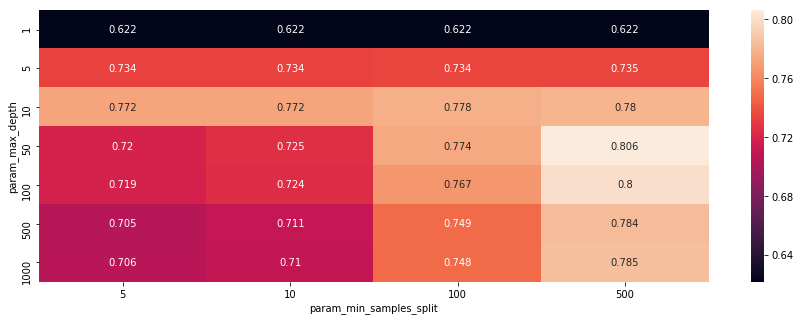

In [47]:
df_decisiontree = pd.DataFrame(model.cv_results_)
# .max() function returns the largest value in the iterable format
scores = df_decisiontree.groupby(['param_max_depth', 'param_min_samples_split']).max()
# unstack() method in pandas converts the data into unstacked format
AUC_scores = scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_test_score, annot=True, fmt='.3g'); # heatmap on CV data with AUC scores for both hyperparameters


In [48]:
# Displaying CV-AUC scores on both hyperparameters
print("The CV AUC-score for both hyperparameters is : \n", np.round(AUC_scores.mean_test_score,3))

The CV AUC-score for both hyperparameters is : 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.622  0.622  0.622  0.622
5                        0.734  0.734  0.734  0.735
10                       0.772  0.772  0.778  0.780
50                       0.720  0.725  0.774  0.806
100                      0.719  0.724  0.767  0.800
500                      0.705  0.711  0.749  0.784
1000                     0.706  0.710  0.748  0.785


### Heat map on both hyperparameters on Train data

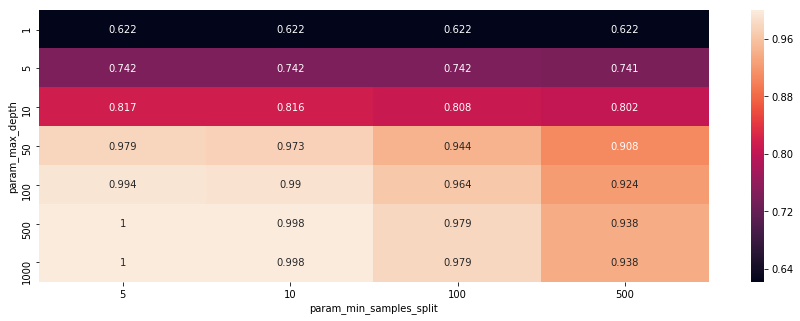

In [49]:
plt.figure(figsize=(15,5))
# heatmap on Train data with AUC scores for both hyperparameters
sns.heatmap(AUC_scores.mean_train_score, annot=True, fmt='.3g');

In [50]:
# Displaying Train-AUC scores on both hyperparameters
print("the Train score for both hyperparameters is \n", np.round(AUC_scores.mean_train_score, 3))

the Train score for both hyperparameters is 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.622  0.622  0.622  0.622
5                        0.742  0.742  0.742  0.741
10                       0.817  0.816  0.808  0.802
50                       0.979  0.973  0.944  0.908
100                      0.994  0.990  0.964  0.924
500                      1.000  0.998  0.979  0.938
1000                     1.000  0.998  0.979  0.938


### [5.4]  Plotting ROC curve and finding AUC score for BoW

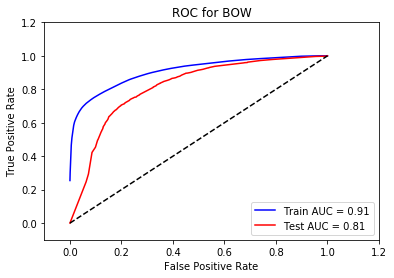

In [51]:
# ROC curve for both Train and test data and finding AUC score for BoW
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(X_train_bow, Y_train)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification for both train and test 
train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(X_test_bow)[:,1])

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC for BOW')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-

From the ROC plot, we got the Train AUC of 0.91 and test ACU of 0.81, which shows that the classifier is working well and predicts correctly.


## [5.5] Confusion matrix for BoW

### Train Confusion matrix for BoW

In [53]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_bow_train = dt_optimal.predict(X_train_bow)
cm = confusion_matrix(Y_train, pred_bow_train) # finding confusion matrix between true data and predicted data
print(cm)

Train confusion matrix
[[ 4026  4580]
 [ 1796 59598]]


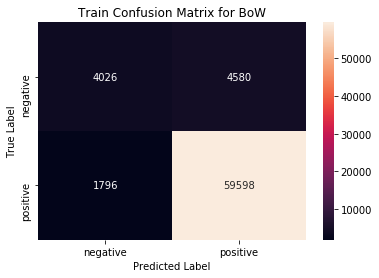

In [54]:
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_bow_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-


A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 4026     FP - 4580

FN - 1796 ,   TP - 59598

where

TN - True negative, True value is negative, and is predicted value is negative.

FP - False positive, True value is negative, but is predicted as positive.

FN - False negative, True value is positive, but is predicted as negative

TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 70000 training points being tested against the model. Out of all values, the classifier/model predicted points as positive 64178 times and negative 5822 times.
2. But in true values, the positive points are 61394 and negative points are 8606.
3. The diagonal values (4026 negative points, 59598 positive points) in the confusion matrix are correctly predicted values by the classifier.



### Test  Confusion matrix for BoW

In [55]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_bow_test = dt_optimal.predict(X_test_bow)
cm = confusion_matrix(Y_test, pred_bow_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[ 1287  2378]
 [ 1035 25300]]


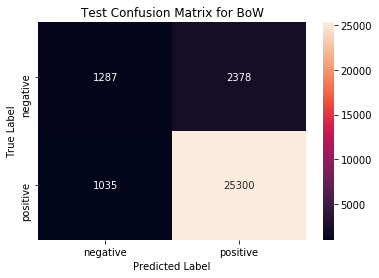

In [56]:
# plot test confusion matrix for BoW
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_bow_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 1287    FP - 2378

FN - 1035 ,  TP - 25300

where

TN - True negative, True value is negative, and is predicted value is negative.

FP - False positive, True value is negative, but is predicted as positive.

FN - False negative, True value is positive, but is predicted as negative

TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 27678 times and negative 2322 times.
2. But in true values(test data), the positive points are 26335 and negative points are 3665.
3. The diagonal values (1287 negative points, 25300 positive points) in the confusion matrix are correctly predicted values by the classifier.



#### Finding TPR, FPR, TNR, FNR values

1. TPR tells, when it's actually yes and how often does classifier predict yes

   TPR = TP/(TP+FN) . TPR also known as Recall


2. FPR tells, when it's actually no, how often does classifier predict yes

   FPR = FP/(FP+TN) 


3. TNR tells, when it's actually no, how often does classifier predict no

   TNR = TN/(TN+FP) 
    

4. FNR tells, When it's actually yes, how often does it predict no

   FNR = FN/(FN+TP) 



### [5.6] Classification report for BoW:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)


2. Recall:- It tells, when the points are positive and how often they are predicted positive.

   Recall = TP / (TP + FN)


3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)


4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)



In [57]:
# calculate the classification report for BoW
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_bow)) 
print('Report:')
print(classification_report(Y_test, pred_bow)) 


Accuracy Score: 0.8862333333333333
Report:
             precision    recall  f1-score   support

          0       0.55      0.35      0.43      3665
          1       0.91      0.96      0.94     26335

avg / total       0.87      0.89      0.87     30000



#### Observation:-

In case of BoW DecisionTree , f1-score, precision gave same accuracy of 87% and recall gave score of 89% accuracy .


### [5.7] Feature Importance for BoW

To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

So we can say that, in Decision Tree we can find feature importance with feature_importances_


In [58]:
clf = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
clf.fit(X_train_bow, Y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:
# Feature importance
def feature_importances_(vectorizer, clf, n=20): # To print top 20 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names)) # fns- feature names
    top = coefs_with_fns[:-(n + 1):-1] # top 20 features
    #top = (zip(coefs_with_fns[:-(n + 1):-1], coefs_with_fns[:n])) 
    print("Feature Importances\t\tfeatures")
    for (coefs_with_fns_1, fn_1) in top:  # To print top 20 features
        print("%.4f\t\t\t\t%-15s" % (coefs_with_fns_1, fn_1))
feature_importances_(count_vect, clf)

Feature Importances		features
0.0835				not            
0.0484				great          
0.0456				worst          
0.0412				money          
0.0383				disappointed   
0.0357				best           
0.0345				terrible       
0.0210				delicious      
0.0187				horrible       
0.0185				return         
0.0183				love           
0.0159				good           
0.0152				disappointment 
0.0142				awful          
0.0136				disappointing  
0.0124				threw          
0.0120				loves          
0.0119				perfect        
0.0114				nice           
0.0112				waste          


### [5.8]  Visualizing the Decision tree for BoW

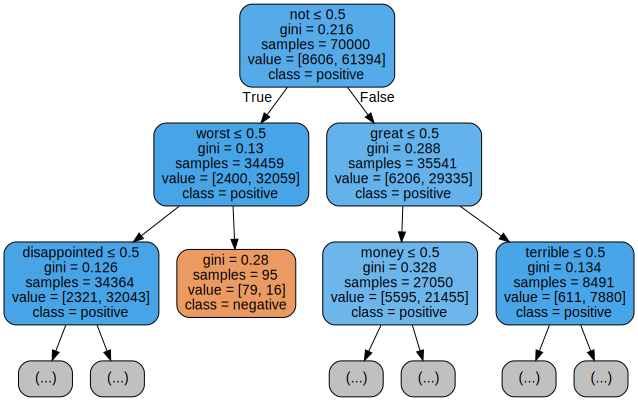

In [65]:
from graphviz import Source
import graphviz
from sklearn import tree
from IPython.display import Image
import pydotplus

target_class = ['negative','positive']
vectorizer = CountVectorizer()
vect = vectorizer.fit_transform(X_train)
vectorizer.get_feature_names()

bow_tree = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
bow_tree.fit(vect, Y_train)

bow_dt = tree.export_graphviz(bow_tree, max_depth= 2, out_file = None, feature_names = vectorizer.get_feature_names(),class_names = target_class, filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(bow_dt)
graph


In [66]:
# reference - https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn/27818170
# saving the above decision tree in png format

graph.format = 'png'
graph.render('dtree',view=True)

'dtree.png'

# 6. TFIDF

### Sample the dataset 

I am taking sample of 60k points for TFIDF due to long computation time for TFIDF which is taking hours together and I am not able to run this entire assignment in 24hrs, and due to less computational power of my system. Please consider it .

In [67]:
total_score_new = final_data.iloc[:60000,:]
print(total_score_new.shape)
print(total_score_new['Score'].value_counts())

(60000, 12)
1    53147
0     6853
Name: Score, dtype: int64


In [68]:
total_score_new.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny


### Splitting data into Train and Test data for TFIDF

In [69]:
# splitting the data into train, test data
from sklearn.cross_validation import train_test_split
X1 = total_score_new['CleanedText']
Y1 = total_score_new['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X1, Y1, test_size = 0.3, random_state = 0)

print('X_train_new, Y_train_new', X_train_new.shape, Y_train_new.shape)
print('X_test_new, Y_test_new', X_test_new.shape, Y_test_new.shape)


X_train_new, Y_train_new (42000,) (42000,)
X_test_new, Y_test_new (18000,) (18000,)


In [70]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
X_train_tfidf = tf_idf_vect.fit_transform(X_train_new)
X_test_tfidf = tf_idf_vect.transform(X_test_new)

print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the type of TFIDF vectorizer ",type(X_test_tfidf))

print(X_train_tfidf.get_shape())
print(X_test_tfidf.get_shape())

print("the number of unique words ", X_train_tfidf.get_shape()[1])
print("the number of unique words ", X_test_tfidf.get_shape()[1])


the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(42000, 820140)
(18000, 820140)
the number of unique words  820140
the number of unique words  820140


In [71]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

820140

In [72]:
print("some sample features(unique words in the corpus) are:")
features[50000:50010]

some sample features(unique words in the corpus) are:


['banana mixture',
 'banana muffins',
 'banana no',
 'banana not',
 'banana nut',
 'banana nutbread',
 'banana nuts',
 'banana one',
 'banana ones',
 'banana orange']

In [73]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(X_train_tfidf[1,:].toarray()[0],features,20)

In [74]:
top_tfidf

,feature,tfidf
0,bonzai,0.339310
1,bonzai azalea,0.241490
2,purchased bonzai,0.241490
3,azalea,0.226207
4,purchased,0.200410
5,gift,0.158952
6,feel,0.146916
7,plant,0.142519
8,gift visit,0.120745
9,ordering themto,0.120745


### [6.1]  Applying Decision Tree on TFIDF with max_depth and min_samples_split as hyper parameters

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}

model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)

model.fit(X_train_tfidf, Y_train_new)

print("Model with best parameters is :\n", model.best_estimator_)

optimal_max_depth =  model.best_estimator_.max_depth
print("The optimal value of max_depth is :", optimal_max_depth)

optimal_min_samples_split = model.best_estimator_.min_samples_split
print("The optimal value of minimum samples split is:", optimal_min_samples_split)


Model with best parameters is :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of max_depth is : 50
The optimal value of minimum samples split is: 500


In [76]:
# get the score on test data 
print(model.score(X_test_tfidf, Y_test_new))  


0.7982864745011087


### [6.2] Predicting Test score and Test error for TFIDF with hyperparameters

In [78]:
# Predicting model on test data to find auc-score 
from sklearn.metrics import roc_auc_score

dt_optimal = DecisionTreeClassifier(max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)

# fitting the model
dt_optimal.fit(X_train_tfidf, Y_train_new)

# predict the response
pred_tfidf = dt_optimal.predict(X_test_tfidf)

# evaluate accuracy. Using auc_score as metric to measure accuracy
test_auc_tfidf = roc_auc_score(Y_test_new, pred_tfidf, average = 'weighted') * float(100)
print('\nThe test AUC-score of the DecisionTreeClassifier for optimal hyperparameters in TFIDF is %f%%' % (test_auc_tfidf))



The test AUC-score of the DecisionTreeClassifier for optimal hyperparameters in TFIDF is 63.910620%


In [80]:
# Finding test error
test_error_tfidf = (1 - roc_auc_score(Y_test_new, pred_tfidf, average = 'weighted'))
print("Test Error for DecisionTreeClassifier TFIDF is %.3f%%" % (test_error_tfidf))

Test Error for DecisionTreeClassifier TFIDF is 0.361%


### [6.3] Plotting the performance of Train and CV scores for TFIDF with hyperparameters using Heatmaps

### Heat map for CV scores TFIDF

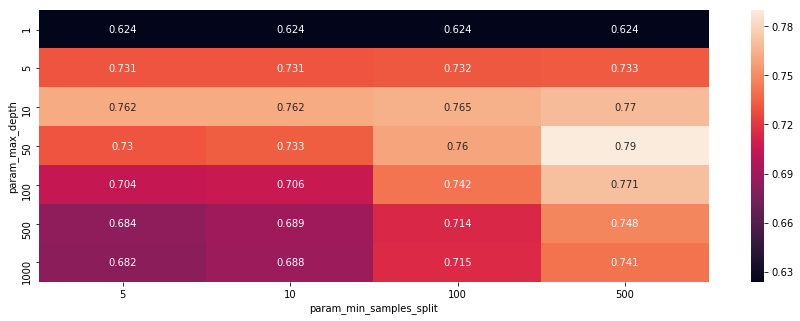

In [81]:
df_decisiontree = pd.DataFrame(model.cv_results_)
# .max() function returns the largest value in the iterable format
scores = df_decisiontree.groupby(['param_max_depth', 'param_min_samples_split']).max()
# unstack() method in pandas converts the data into unstacked format
AUC_scores = scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_test_score, annot=True, fmt='.3g');


In [82]:
print("The CV AUC-score for both hyperparameters is : \n", np.round(AUC_scores.mean_test_score,3))

The CV AUC-score for both hyperparameters is : 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.624  0.624  0.624  0.624
5                        0.731  0.731  0.732  0.733
10                       0.762  0.762  0.765  0.770
50                       0.730  0.733  0.760  0.790
100                      0.704  0.706  0.742  0.771
500                      0.684  0.689  0.714  0.748
1000                     0.682  0.688  0.715  0.741


### Heat map for Train scores TFIDF

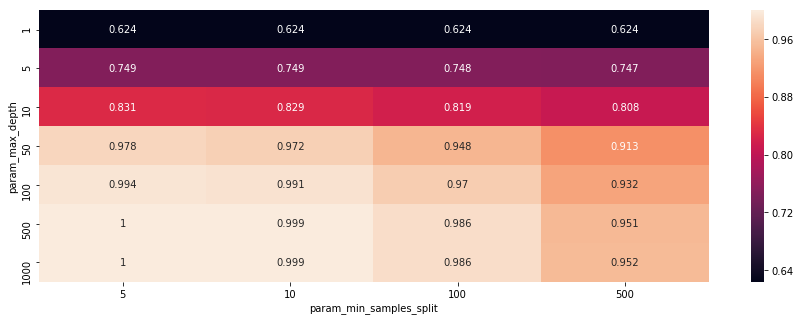

In [83]:
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_train_score, annot=True, fmt='.3g');

In [84]:
print("the Train score for both hyperparameters is \n", np.round(AUC_scores.mean_train_score, 3))

the Train score for both hyperparameters is 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.624  0.624  0.624  0.624
5                        0.749  0.749  0.748  0.747
10                       0.831  0.829  0.819  0.808
50                       0.978  0.972  0.948  0.913
100                      0.994  0.991  0.970  0.932
500                      1.000  0.999  0.986  0.951
1000                     1.000  0.999  0.986  0.952


### [6.4]  Plotting ROC curve and finding AUC score for TFIDF

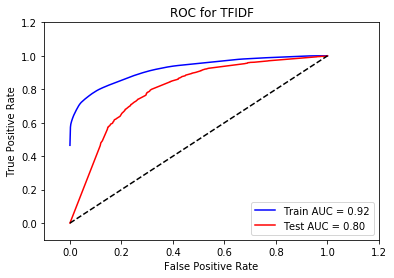

In [85]:
# ROC curve and AUC for TFIDF
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(X_train_tfidf, Y_train_new)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
train_fpr, train_tpr, thresholds = roc_curve(Y_train_new, Y_prob.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test_new, Y_prob.predict_proba(X_test_tfidf)[:,1])

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC for TFIDF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [6.5]  Confusion matrix

### Confusion matrix for TFIDF Train data

In [86]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_tfidf_train = dt_optimal.predict(X_train_tfidf)
cm = confusion_matrix(Y_train_new, pred_tfidf_train) # finding confusion matrix between true data and predicted data
print(cm)

Train confusion matrix
[[ 2308  2495]
 [  962 36235]]


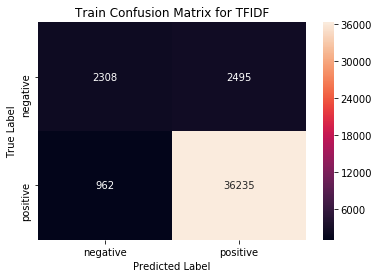

In [87]:
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train_new, pred_tfidf_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Confusion matrix for TFIDF Test data

In [88]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_tfidf_test = dt_optimal.predict(X_test_tfidf)
cm = confusion_matrix(Y_test_new, pred_tfidf_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[  672  1378]
 [  791 15159]]


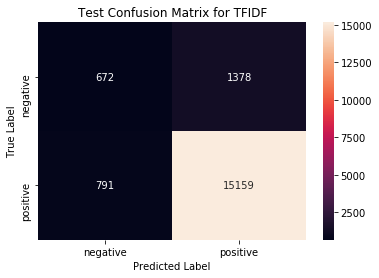

In [89]:
# plot confusion matrix for TFIDF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test_new, pred_tfidf_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 672   FP - 1378

FN - 791 , TP - 15159

where

TN - True negative, True value is negative, and is predicted value is negative.

FP - False positive, True value is negative, but is predicted as positive. 

FN - False negative, True value is positive, but is predicted as negative 

TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 18000 points being tested against the model. 
2. Out of all values, the classifier/model predicted points as positive 16537 times and negative 1463 times. 
3. But in true values(test data), the positive points are 15950 and negative points are 2050. 
4. The diagonal values (672 negative points, 15159 positive points) in the confusion matrix are correctly predicted values by the classifier.


### [6.6]  Classification report for TFIDF:-


In [90]:
# calculate the classification report for TFIDF
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test_new, pred_tfidf)) 
print('Report:')
print(classification_report(Y_test_new, pred_tfidf)) 


Accuracy Score: 0.8795
Report:
             precision    recall  f1-score   support

          0       0.46      0.33      0.38      2050
          1       0.92      0.95      0.93     15950

avg / total       0.86      0.88      0.87     18000



#### Observation:-

In case of TFIDF DecisionTress, accuracy, f1-score, precision all gave same score of 75% accuracy .


### [6.7]  Feature Importance for TFIDF

To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

In [91]:
clf = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
clf.fit(X_train_tfidf, Y_train_new)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [92]:
def feature_importances_(vectorizer, clf, n=20): # To print top 20 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names)) # fns- feature names
    top = coefs_with_fns[:-(n + 1):-1]
    print("Feature Importances\t\tfeatures")
    for (coef_with_fns_1, fn_1) in top:  # For positive and negative classes to print top 20 features
        print("\t%.4f \t\t\t%-15s" % (coef_with_fns_1, fn_1))
feature_importances_(tf_idf_vect, clf)

Feature Importances		features
	0.0837 			not            
	0.0462 			great          
	0.0363 			worst          
	0.0324 			disappointed   
	0.0308 			not buy        
	0.0295 			horrible       
	0.0292 			money          
	0.0271 			not recommend  
	0.0257 			awful          
	0.0252 			best           
	0.0224 			terrible       
	0.0211 			not worth      
	0.0172 			threw          
	0.0150 			disappointment 
	0.0142 			ok             
	0.0122 			disappointing  
	0.0116 			refund         
	0.0103 			stale          
	0.0102 			thought        
	0.0099 			return         


### [6.8]  Visualizing Decision Tree for TFIDF

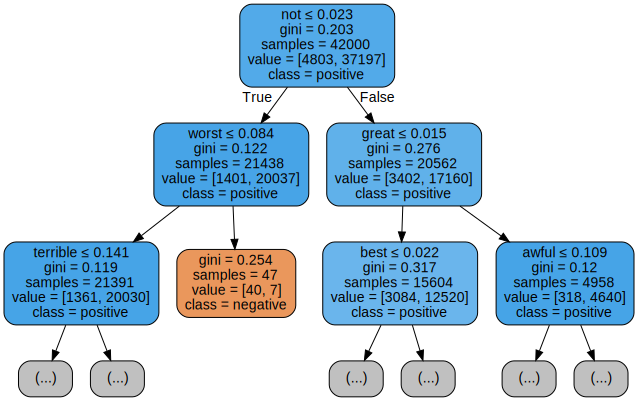

In [93]:
from graphviz import Source
import graphviz
from sklearn import tree
from IPython.display import Image
import pydotplus

target_class = ['negative','positive']
tfidf_vect = TfidfVectorizer()
vect = tfidf_vect.fit_transform(X_train_new)
#tfidf_vect.get_feature_names()

tfidf_tree = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
tfidf_tree.fit(vect, Y_train_new)

tfidf_dt = tree.export_graphviz(tfidf_tree, max_depth= 2, out_file = None, feature_names = tfidf_vect.get_feature_names(), 
                                class_names = target_class, filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(tfidf_dt)
graph



In [94]:
# reference - https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn/27818170

graph.format = 'png'
graph.render('dtree',view=True)

'dtree.png'

# 7. Word2Vec

In [95]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [96]:
# One sentence is converted into a list
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

purchased wedge oro antico central market cost say impressed looking hard cheese add cheese mixture bacon wrapped jalapenos turned great choice usually use parmesan really wanted try something new also used grated cheese caesar salad sharp flavor went great dressingby oro antico bold cheese great nose soft finish great paired red white wines looking hard cheese whatever reason give oro antico try think pleasantly surprised
*****************************************************************
['purchased', 'wedge', 'oro', 'antico', 'central', 'market', 'cost', 'say', 'impressed', 'looking', 'hard', 'cheese', 'add', 'cheese', 'mixture', 'bacon', 'wrapped', 'jalapenos', 'turned', 'great', 'choice', 'usually', 'use', 'parmesan', 'really', 'wanted', 'try', 'something', 'new', 'also', 'used', 'grated', 'cheese', 'caesar', 'salad', 'sharp', 'flavor', 'went', 'great', 'dressingby', 'oro', 'antico', 'bold', 'cheese', 'great', 'nose', 'soft', 'finish', 'great', 'paired', 'red', 'white', 'wines', 'lo

In [97]:
# Train the word2vec model for Train data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_train = gensim.models.Word2Vec(list_of_sent_train, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_train = list(w2v_model_train.wv.vocab)
print(len(words_train))

# prints 50 words
print("sample words ", words_train[0:50])

17076
sample words  ['purchased', 'wedge', 'oro', 'central', 'market', 'cost', 'say', 'impressed', 'looking', 'hard', 'cheese', 'add', 'mixture', 'bacon', 'wrapped', 'jalapenos', 'turned', 'great', 'choice', 'usually', 'use', 'parmesan', 'really', 'wanted', 'try', 'something', 'new', 'also', 'used', 'grated', 'caesar', 'salad', 'sharp', 'flavor', 'went', 'bold', 'nose', 'soft', 'finish', 'paired', 'red', 'white', 'wines', 'whatever', 'reason', 'give', 'think', 'pleasantly', 'surprised', 'not']


In [98]:
# This is W2V for Test data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    

In [99]:
# One sentence is converted into a list
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

love product perfect serving size one counting carbs dietiing also good camping vacationon rundisappointed condition box completely crunchedthankfully contents survived
*****************************************************************
['love', 'product', 'perfect', 'serving', 'size', 'one', 'counting', 'carbs', 'dietiing', 'also', 'good', 'camping', 'vacationon', 'rundisappointed', 'condition', 'box', 'completely', 'crunchedthankfully', 'contents', 'survived']


In [100]:
# Train the word2vec model for Test data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

# prints 50 words
print("sample words ", words_test[0:50])

10937
sample words  ['love', 'product', 'perfect', 'serving', 'size', 'one', 'counting', 'carbs', 'also', 'good', 'camping', 'condition', 'box', 'completely', 'contents', 'survived', 'purchased', 'butter', 'chicken', 'curry', 'packs', 'amazon', 'great', 'sale', 'skeptical', 'taste', 'low', 'behold', 'way', 'exceeded', 'expectations', 'not', 'meat', 'eaters', 'added', 'tofu', 'cauliflower', 'instead', 'impressed', 'authentic', 'compared', 'restaurants', 'nothing', 'beats', 'fresh', 'packet', 'goodness', 'could', 'rival', 'indian']


## [7.1]  Avg-W2V

In [101]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            vec = w2v_model_train.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_train.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

70000
50


In [102]:
# average Word2Vec for Test data
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


### [7.2] Applying Decision Tree on AvgW2V with max_depth and min_samples_split as hyper parameters

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}

model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)

model.fit(sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)

optimal_max_depth =  model.best_estimator_.max_depth
print("The optimal value of max_depth is :", optimal_max_depth)

optimal_min_samples_split = model.best_estimator_.min_samples_split
print("The optimal value of minimum samples split is:", optimal_min_samples_split)


Model with best parameters is :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of max_depth is : 10
The optimal value of minimum samples split is: 500


In [105]:
# get the score on test data 
print(model.score(sent_vectors_test, Y_test))  


0.6912813054382988


### [7.3]  Predicting Test score and Test error for AvgW2V with hyperparameters

In [107]:
# Predicting model on test data to find auc-score 
from sklearn.metrics import roc_auc_score

dt_optimal = DecisionTreeClassifier(max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)

# fitting the model
dt_optimal.fit(sent_vectors_train, Y_train)

# predict the response
pred_w2v = dt_optimal.predict(sent_vectors_test)

# evaluate accuracy. Using AUC_score as metric to measure accuracy,
test_auc_w2v = roc_auc_score(Y_test, pred_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the DecisionTreeClassifier for optimal hyperparamters in AVGW2V is %f%%' % (test_auc_w2v))



The test AUC-score of the DecisionTreeClassifier for optimal hyperparamters in AVGW2V is 59.026454%


In [108]:
# Finding test error
test_error_w2v = (1 - roc_auc_score(Y_test, pred_w2v, average = 'weighted')) 
print("Test Error for DecisionTreeClassifier AVGW2V is %.3f%%" % (test_error_w2v))

Test Error for DecisionTreeClassifier AVGW2V is 0.410%


### [7.4]  Plotting the performance of Train and CV scores for AvgW2V with hyperparameters using Heatmaps

### Heat map for CV scores AvgW2V

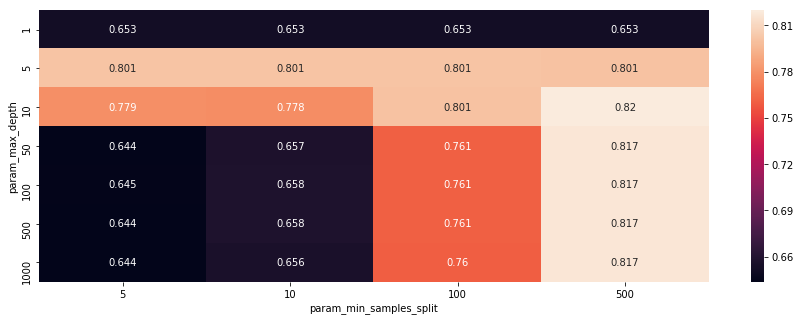

In [109]:
df_decisiontree = pd.DataFrame(model.cv_results_)
# .max() function returns the largest value in the iterable format
scores = df_decisiontree.groupby(['param_max_depth', 'param_min_samples_split']).max()
# unstack() method in pandas converts the data into unstacked format
AUC_scores = scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_test_score, annot=True, fmt='.3g');


In [110]:
print("The CV AUC-score for both hyperparameters is : \n", np.round(AUC_scores.mean_test_score,3))

The CV AUC-score for both hyperparameters is : 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.653  0.653  0.653  0.653
5                        0.801  0.801  0.801  0.801
10                       0.779  0.778  0.801  0.820
50                       0.644  0.657  0.761  0.817
100                      0.645  0.658  0.761  0.817
500                      0.644  0.658  0.761  0.817
1000                     0.644  0.656  0.760  0.817


### Heat map for Train scores AvgW2V

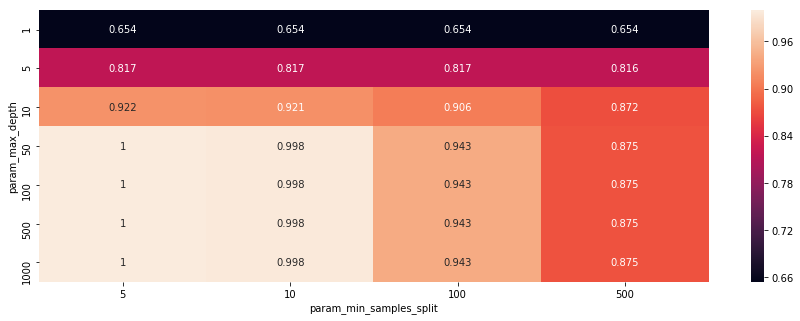

In [113]:
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_train_score, annot=True, fmt='.3g');

In [114]:
print("the Train score for both hyperparameters is \n", np.round(AUC_scores.mean_train_score, 3))

the Train score for both hyperparameters is 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.654  0.654  0.654  0.654
5                        0.817  0.817  0.817  0.816
10                       0.922  0.921  0.906  0.872
50                       1.000  0.998  0.943  0.875
100                      1.000  0.998  0.943  0.875
500                      1.000  0.998  0.943  0.875
1000                     1.000  0.998  0.943  0.875


### [7.5]  Plotting ROC curve and finding AUC score for AvgW2V

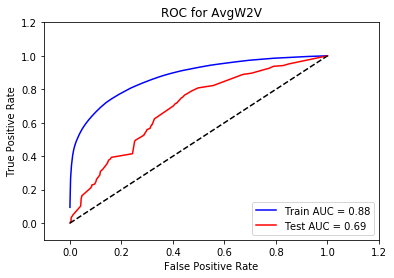

In [115]:
# ROC curve and AUC for Avgw2v
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(sent_vectors_train, Y_train)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(sent_vectors_test)[:,1])

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC for AvgW2V')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [7.6] Confusion matrix

### Confusion matrix for Train data AvgW2V

In [116]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_w2v_train = dt_optimal.predict(sent_vectors_train)
cm = confusion_matrix(Y_train, pred_w2v_train) # finding confusion matrix between true data and predicted data
print(cm)

Train confusion matrix
[[ 2243  6363]
 [ 1207 60187]]


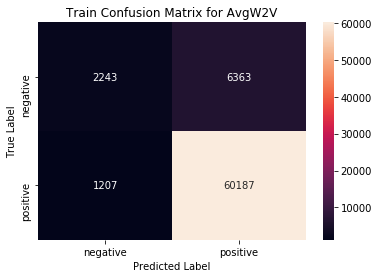

In [117]:
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_w2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###  Confusion matrix for Test data AvgW2V

In [118]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_w2v_test = dt_optimal.predict(sent_vectors_test)
cm = confusion_matrix(Y_test, pred_w2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[  869  2796]
 [ 1490 24845]]


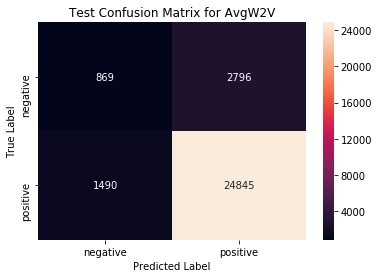

In [119]:
# plot confusion matrix for Avgw2v
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_w2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [7.7]  Classification report for AvgW2v

In [120]:
# calculate the classification report for AvgW2V
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_w2v)) 


Accuracy Score: 0.8571333333333333
Report:
             precision    recall  f1-score   support

          0       0.37      0.24      0.29      3665
          1       0.90      0.94      0.92     26335

avg / total       0.83      0.86      0.84     30000



# 8. TFIDF-W2V

In [121]:
model = TfidfVectorizer()
tfidf_train_matrix = model.fit_transform(X_train)
tfidf_test_matrix = model.transform(X_test)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [122]:
print(tfidf_train_matrix.get_shape()) 
print(tfidf_test_matrix.get_shape()) 


(70000, 90082)
(30000, 90082)


### [8.1] TFIDF-W2V for Train data

In [123]:
# TF-IDF weighted Word2Vec for Train data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            try:
                vec = w2v_model_train.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [05:25<00:00, 215.10it/s]


### [8.2]  TFIDF-W2V for Test data

In [124]:
# TF-IDF weighted Word2Vec for Test data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            try:
                vec = w2v_model_test.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            #tf_idf = tfidf_test_matrix[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:36<00:00, 310.41it/s]


### [8.3] Applying Decision Tree on TFIDF-W2V with max_depth and min_samples_split as hyper parameters

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}

model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)

model.fit(tfidf_sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)

optimal_max_depth =  model.best_estimator_.max_depth
print("The optimal value of max_depth is :", optimal_max_depth)

optimal_min_samples_split = model.best_estimator_.min_samples_split
print("The optimal value of minimum samples split is:", optimal_min_samples_split)


Model with best parameters is :
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of max_depth is : 10
The optimal value of minimum samples split is: 500


In [127]:
# get the score on test data 
print(model.score(tfidf_sent_vectors_test, Y_test))  


0.6924512609205922


### [8.4]  Predicting Test score and Test error for TFIDF-W2V

In [129]:
# Predicting model on test data to find auc-score 
from sklearn.metrics import roc_auc_score

dt_optimal = DecisionTreeClassifier(max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)

# fitting the model
dt_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
pred_tfidf_w2v = dt_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy. Using auc_score as metric to measure accuracy,
test_auc_tfidfw2v = roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the DecisionTreeClassifier for optimal hyperparameters in TFIDF-W2V is %f%%' % (test_auc_tfidfw2v))



The test AUC-score of the DecisionTreeClassifier for optimal hyperparameters in TFIDF-W2V is 55.607949%


In [130]:
# Finding test error
test_error_tfidf_w2v = (1 - roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted')) 
print("Test Error for DecisionTreeClassifier TFIDF-W2V is %.3f%%" % (test_error_tfidf_w2v))

Test Error for DecisionTreeClassifier TFIDF-W2V is 0.444%


### [8.5]  Plotting the performance of Train and CV scores for TFIDF-W2V with hyperparameters using Heatmaps

### Heat map for CV scores TFIDF-W2V

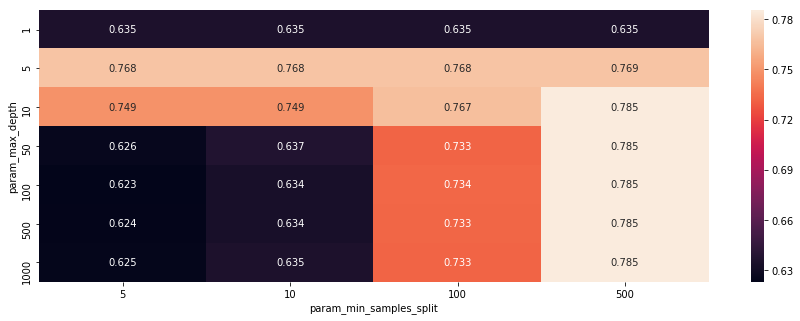

In [131]:
df_decisiontree = pd.DataFrame(model.cv_results_)
# .max() function returns the largest value in the iterable format
scores = df_decisiontree.groupby(['param_max_depth', 'param_min_samples_split']).max()
# unstack() method in pandas converts the data into unstacked format
AUC_scores = scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_test_score, annot=True, fmt='.3g');


In [132]:
print("The CV AUC-score for both hyperparameters is : \n", np.round(AUC_scores.mean_test_score,3))

The CV AUC-score for both hyperparameters is : 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.635  0.635  0.635  0.635
5                        0.768  0.768  0.768  0.769
10                       0.749  0.749  0.767  0.785
50                       0.626  0.637  0.733  0.785
100                      0.623  0.634  0.734  0.785
500                      0.624  0.634  0.733  0.785
1000                     0.625  0.635  0.733  0.785


### Heat map for Train scores TFIDF-W2V

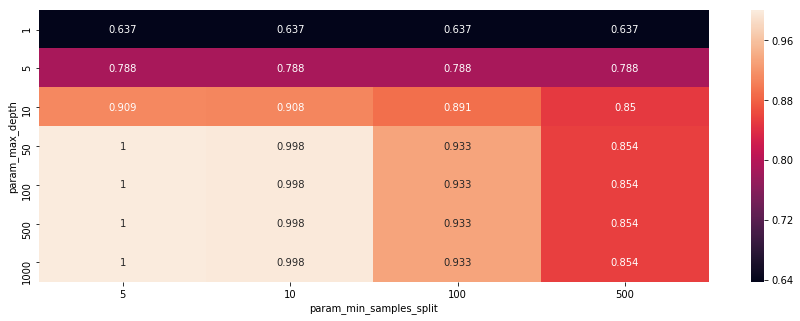

In [133]:
plt.figure(figsize=(15,5))
sns.heatmap(AUC_scores.mean_train_score, annot=True, fmt='.3g');

In [134]:
print("the Train score for both hyperparameters is \n", np.round(AUC_scores.mean_train_score, 3))

the Train score for both hyperparameters is 
 param_min_samples_split    5      10     100    500
param_max_depth                                    
1                        0.637  0.637  0.637  0.637
5                        0.788  0.788  0.788  0.788
10                       0.909  0.908  0.891  0.850
50                       1.000  0.998  0.933  0.854
100                      1.000  0.998  0.933  0.854
500                      1.000  0.998  0.933  0.854
1000                     1.000  0.998  0.933  0.854


### [8.6]  Plotting ROC curve and finding AUC score for TFIDF-W2V

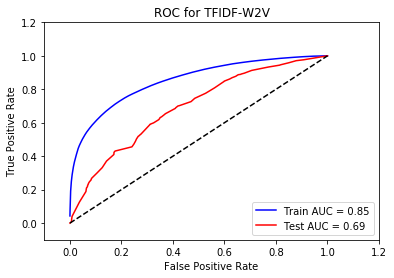

In [135]:
# ROC curve and AUC for TFIDF-W2V
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(tfidf_sent_vectors_train, Y_train)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(tfidf_sent_vectors_test)[:,1])

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC for TFIDF-W2V')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [8.7] Confusion matrix 

### Confusion matrix for TFIDF-W2V Train data

In [136]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_tfidf_w2v_train = dt_optimal.predict(tfidf_sent_vectors_train)
cm = confusion_matrix(Y_train, pred_tfidf_w2v_train) # finding confusion matrix between true data and predicted data
print(cm)

Train confusion matrix
[[ 1995  6611]
 [ 1202 60192]]


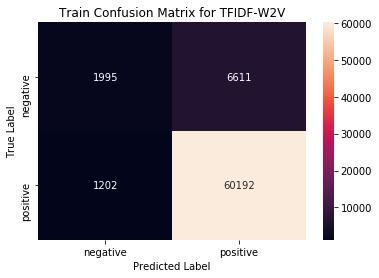

In [137]:
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_tfidf_w2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Confusion matrix for TFIDF-W2V Test data

In [138]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_tfidf_w2v_test = dt_optimal.predict(tfidf_sent_vectors_test)
cm = confusion_matrix(Y_test, pred_tfidf_w2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[  532  3133]
 [  869 25466]]


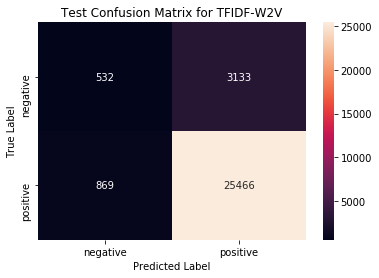

In [139]:
# plot confusion matrix for TFIDF-W2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf_w2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [8.8] Classification report for TFIDF-W2V


In [140]:
# calculate the classification report for TFIDF-W2V
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf_w2v)) 


Accuracy Score: 0.8666
Report:
             precision    recall  f1-score   support

          0       0.38      0.15      0.21      3665
          1       0.89      0.97      0.93     26335

avg / total       0.83      0.87      0.84     30000



## 9. Models Summarization

In [141]:
from pandas import DataFrame
DecisionTrees = {'Vectorizer':['BoW', 'TFIDF', 'AVG-W2V', 'TFIDF-W2V'], 'Model':['DecisionTreeClassifier','DecisionTreeClassifier','DecisionTreeClassifier','DecisionTreeClassifier'], 
                       'Hyper parameter max_depth':['50','50','10','10'],
                       'Hyper parameter min_samples_split':['500','500','500','500'],
                       'AUC-score':['65.59','63.91','59.02','55.60'],
                       'Test error':['0.34','0.36','0.41','0.44'],
                       'Train AUC Score':['0.91','0.92','0.88','0.85'],
                       'Test AUC score':['0.81','0.80','0.69','0.69']}

In [142]:
Final_conclusions = DataFrame(DecisionTrees)
Final_conclusions

,Vectorizer,Model,Hyper parameter max_depth,Hyper parameter min_samples_split,AUC-score,Test error,Train AUC Score,Test AUC score
0,BoW,DecisionTreeClassifier,50,500,65.59,0.34,0.91,0.81
1,TFIDF,DecisionTreeClassifier,50,500,63.91,0.36,0.92,0.80
2,AVG-W2V,DecisionTreeClassifier,10,500,59.02,0.41,0.88,0.69
3,TFIDF-W2V,DecisionTreeClassifier,10,500,55.60,0.44,0.85,0.69


## 10. Conclusions:-

1. From the above observations, featurizations BoW and TFIDF have good AUC score on test data.
2. All the featurizations have good Train AUC which I got through ROC curve but, BoW and TFIDF has more Test AUC score through ROC curve.
3. So BoW and TFIDF trained by DecisionTreeClassifier are working well on unseen data, compared to other featurizations AvgW2V and TFIDF-W2V.
